# 计算机模拟第五周作业

In [1]:
from __future__ import print_function, division

# 这句话是非标准的python，用于ipthon或jupyter这样的系统中，表示绘图即刻自动展开。
%matplotlib inline

# 这里把全部Warning过滤掉了. 
# 参见https://docs.python.org/2/library/warnings.html
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(250)

## 心形曲线绘制

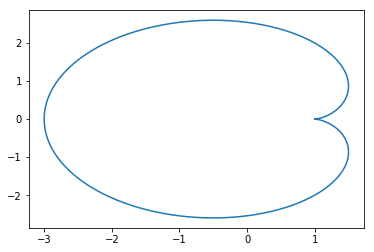

In [2]:
t = np.linspace(0 , 2 * np.pi, 1024)
X = 2 * np.cos(t) - np.cos(2*t)
Y = 2 * np.sin(t) - np.sin(2*t)
plt.plot(X, Y)
plt.show()

## 计算面积

不妨将该曲线沿 x 轴负方向平移一个单位，得到的曲线的参数方程为：

\begin{equation}
\left\{
\begin{array} \
x=2cos(t)-cos(2t)-1=2cos(t)(1-cos(t))\\
y=2sin(t)-sin(2t)=2sin(t)(1-cos(t))\\
\end{array}
\right.
\end{equation}

新曲线的图像如下所示。

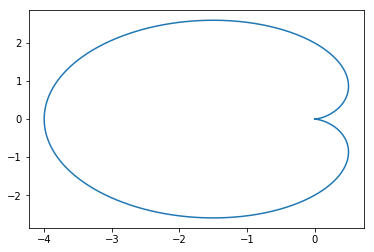

In [3]:
t = np.linspace(0 , 2 * np.pi, 1024)
X = 2 * np.cos(t) - np.cos(2*t) - 1
Y = 2 * np.sin(t) - np.sin(2*t)
plt.plot(X, Y)
plt.show()

计算原图形面积等价于计算新的图形的面积，并且，新的曲线的极坐标方程为：

$$
r = 2(1 - cos \varphi)
$$

因此，用 Monte Carlo 方法计算该图形面积的步骤为：

* 生成两个 [0, 1] 均匀分布序列
* 将两个序列分别变换到 [-4, 1] 与 [-3, 3]
* 通过极坐标方程判断每个二维点是否落在图形内
* 计算面积估计值，标准误差

In [4]:
# Monte Carlo 方法计算心形线面积
# 此处保存 inside 是为了方便计算置信区间
def area_heart(times):
    inside = 0
    dots = np.random.rand(2, times)
    for i in range(times):
        # 区间变换（线性映射）
        x = 5 * dots[0, i] - 4
        y = 6 * dots[1, i] - 3
        # 判断点是否在图形内
        r = (x**2 + y**2)**0.5
        if r == 0:
            inside += 1
        else:
            cos_phi = x / r
            if  r <= 2 * (1 - cos_phi):
                inside += 1
        # 面积估计值
        area = 30 * inside / times
    return inside, area

令取样次数为 10000，即可得到面积与误差的估计值。

In [5]:
inside, area = area_heart(10000)
std_error = ((area)*(30-area)/(10000-1))**0.5
print(area, std_error)

18.789 0.14514287631659553


## 置信区间计算

Beta 分布与 F 分布有以下关系：

若 
$$X \sim \beta(a, b), \quad a, b \in N_+,$$
则 
$$Y = \frac{b}{a} \frac{X}{1-X} \sim F(2a, 2b).$$

因此，讲义中 Beta 分布函数的求根问题可以转化为求 F 分位数，而这可以通过调用 scipy.stats 库中的函数来解决，省去了一些编程的麻烦。具体来说，我们需要求解的问题为：

$$ P(\beta(S, n-S+1) \leq \lambda_L) = \frac{\delta}{2},\quad P(\beta(S+1, n-S) \leq \lambda_U) = 1 - \frac{\delta}{2} $$

其中 $P(\beta(a, b) \leq x)$ 表示 $\beta(a, b)$ 的分布函数，$\lambda_L, \lambda_U$ 分别表示要求的置信下限，置信上限。根据 $\frac{x}{1-x}$ 在 $(0,1)$ 上的单调递增性，我们有：

\begin{equation}
\begin{split}
\frac{\delta}{2} &= P(\beta(S, n-S+1) \leq \lambda_L) \\
&=P(\frac{\beta(S, n-S+1)}{1-\beta(S, n-S+1)} \leq \frac{\lambda_L}{1-\lambda_L}) \\
&=P(F(2S, 2(n-S+1)) \leq \frac{n-S+1}{S}\frac{\lambda_L}{1-\lambda_L})
\end{split}
\end{equation}

从而：

$$ \frac{n-S+1}{S}\frac{\lambda_L}{1-\lambda_L} = F_{1-\delta/2}(2S, 2(n-S+1))$$

其中 $ F_{1-\alpha}(a, b) $ 为 $F(a,b)$ 的上分位数。从这个方程我们可以很容易解出 $\lambda_L$，其中分位数的计算只需借助 scipy.stats 库中的 $f.isf(\alpha, a, b)$ 函数。类似的，对于置信上限，我们有：

$$ \frac{n-S}{S+1}\frac{\lambda_U}{1-\lambda_U} = F_{\delta/2}(2(S+1), 2(n-S))$$

根据上述结论，我们可以写出计算置信区间的代码：

In [7]:
# 导入计算 F 分位数的相关库
from scipy.stats import f

# 置信区间计算
# 1-delta: 置信度
# S: 样本落入区域次数
# n: 取样次数
# A: 面积放缩倍数，即样本来源区域的面积
# [lower, upper]: 置信区间
def confidence(delta, n, S, A):
    f1 = f.isf(1-delta/2, 2*S, 2*(n-S+1))
    lower = f1*S/(n-S+1+f1*S)
    f2 = f.isf(delta/2, 2*(S+1), 2*(n-S))
    upper = f2*(S+1)/(n-S+f2+f2*S)
    return lower*A, upper*A

之前的抽样结果所得到的置信区间为：

In [8]:
confidence(0.01, 10000, inside, 30)

(18.559851468874353, 19.30838407309703)

## 统计计算结果

该图形的精确面积为 $6\pi$，据此我们可以统计出各次模拟绝对误差的情况。

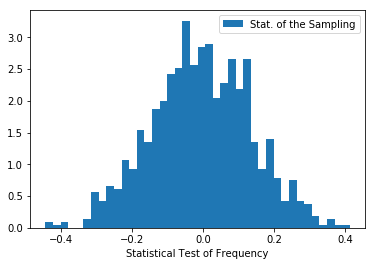

In [9]:
T = 1000  # 模拟次数
n = 10000  # 取样次数
delta = 0.01  # 1 - 置信度
abs_err = np.zeros(T)  # 绝对误差
confi = 0  # 待估参数落入置信区间的次数
for i in range(T):
    inside, area = area_heart(n)
    abs_err[i] = area - 6*np.pi
    ## 此处的代码用来验证计算的置信区间的正确性
    ## 由于求分位数时间很长，这段代码会运行很久，不需要的话可以将下面三行注释
    lower, upper = confidence(delta, n, inside, 30)
    if lower <= 6*np.pi and upper >= 6*np.pi:
       confi += 1
plt.hist(abs_err, bins=40, normed=True, label="Stat. of the Sampling");
plt.legend()
plt.xlabel(r"Statistical Test of Frequency")
plt.savefig("heart.pdf")

从上面的结果可知，我们对面积的估计是有效的。如果运行上面代码时没有注释掉求置信区间的部分，我们还可以通过 confi 算出待估参数落入置信区间的频率。理论上来说，这个值应该十分接近置信度 $1-\delta = 0.99$。(我在自己的电脑试着跑了一次 $T =1000$ 的统计，得到的值为 0.993)

In [10]:
confi / T

0.993